# Mongolia 

In [1]:
import sys
import numpy as np
from osgeo import gdal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import os
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import rasterio as rio
from rasterio.mask import mask
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from glob import glob

import matplotlib.pyplot as plt
# %matplotlib inline

import utils
import util_preprocess

## Set directories here

In [22]:
# Get abosolute path of the current folder
FPATH = 'D:/mongolia/mongolia_ml_model/features/'

# Get abosolute output path of te current folder
OUTPUT = 'D:/mongolia/mongolia_ml_model/output/'

target = 'class'

# Random seed
# The random seed
random_seed = 42

# Set random seed in numpy
import numpy as np
np.random.seed(random_seed)

## Stack SpFea in VRT

In [3]:
# Load data to VRT for processing 
files = sorted(glob(f'{FPATH}/*/*.tif'))
# print(files)

# vrt_options = gdal.BuildVRTOptions(separate=True)
# vrt =  gdal.BuildVRT(f'{OUTPUT}/data_output/mgl_spfea.vrt', files, options=vrt_options)
# vrt = None

## Load VRT and read to array 

In [9]:
PATH= 'D:/mongolia/mongolia_ml_model/output/data_output/mgl_spfea.vrt'
img = utils.read_image(PATH)
img_arr=img[0]
img_gt=img[1]
img_georef=img[2]

# Process spfea features, get the width, height and number of bands
n = img_arr.shape[0]
print (n) # number of bands
h = img_arr.shape[1]
print (h) # height
w = img_arr.shape[2]
print (w) # width

138
2379
2490


## Plot images

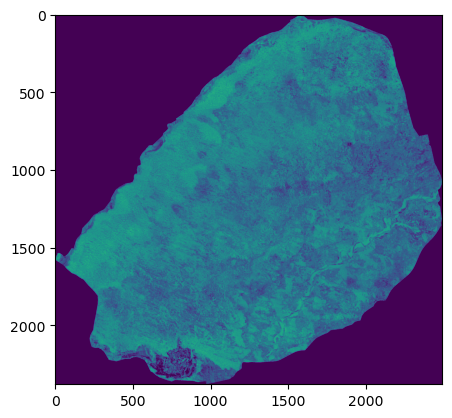

In [10]:
#plot 
plt.imshow(img_arr[9])

## Loading and processind training dataset

In [11]:
PATH_TR='D:/mongolia/mongolia_ml_model/train_mgl_2/train_mgl3.tif'

Tr = rio.open(PATH_TR)
data_loc = Tr.read()
data_loc = np.array(data_loc)
#Print data shape
data_loc.shape

(1, 2379, 2490)

# Concatenate training and features  dataset

In [19]:
# concat 
y=np.array(data_loc[0,...]).reshape(1,h,w)
x=img_arr
data = np.concatenate((y,x),axis=0)
data.shape

(139, 2379, 2490)

## Convert to DataFrame

In [21]:
target = ['class']
# Get band names
bandname = []
for file in files:
    head, tail = os.path.split(file)
    col_names=tail[:-4]
    bandname.append(col_names)
# print(bandname)
bandnames = target+bandname


# %%
# Make dataframe
df=utils.make_data_frame(data, bandnames)

# %%
df_raw = df.loc[df['class'] >=1 ]
df_data = df_raw.copy(deep=True)



(139, 2379, 2490)


## Split data into train, validation and test

In [24]:
from sklearn.model_selection import train_test_split

# Divide the training data into training (80%) and testing (20%)
df_train, df_test = train_test_split(df_data, train_size=0.80, random_state=random_seed)
# Reset the index
df_train, df_test = df_train.reset_index(drop=True), df_test.reset_index(drop=True)

# Divide the training data into training (80%) and validation (20%)
df_train, df_val = train_test_split(df_train, train_size=0.80, random_state=random_seed)
# Reset the index
df_train, df_val = df_train.reset_index(drop=True), df_val.reset_index(drop=True)

print('df_train', df_train.shape)
print('df_val', df_val.shape)
print('df_test', df_test.shape)

df_train (1270, 139)
df_val (318, 139)
df_test (397, 139)


## Handling uncommon features 

In [28]:
# Handling uncommon features
# Call common_var_checker
# See the implementation in pmlm_utilities.ipynb
df_common_var = util_preprocess.common_var_checker(df_train, df_val, df_test, target)

# Print df_common_var
print(df_common_var)

# Get the features in the training data but not in the validation or test data
uncommon_feature_train_not_val_test = np.setdiff1d(df_train.columns, df_common_var['common var'])

# Print the uncommon features
print(pd.DataFrame(uncommon_feature_train_not_val_test, columns=['uncommon feature']))

# Get the features in the validation data but not in the training or test data
uncommon_feature_val_not_train_test = np.setdiff1d(df_val.columns, df_common_var['common var'])

# Print the uncommon features
print(pd.DataFrame(uncommon_feature_val_not_train_test, columns=['uncommon feature']))

# Get the features in the test data but not in the training or validation data
uncommon_feature_test_not_train_val = np.setdiff1d(df_test.columns, df_common_var['common var'])

# Print the uncommon features
print(pd.DataFrame(uncommon_feature_test_not_train_val, columns=['uncommon feature']))

                                  common var
0                                      class
1                          fourier_sc10_mean
2                      fourier_sc10_variance
3                         fourier_sc200_mean
4                     fourier_sc200_variance
..                                       ...
134  sfs_sc40_max_ratio_of_orthogonal_angles
135                            sfs_sc40_mean
136                 sfs_sc40_min_line_length
137                             sfs_sc40_std
138                          sfs_sc40_w_mean

[139 rows x 1 columns]
Empty DataFrame
Columns: [uncommon feature]
Index: []
Empty DataFrame
Columns: [uncommon feature]
Index: []
Empty DataFrame
Columns: [uncommon feature]
Index: []


## Removing uncommon features 

In [29]:
# Remove the uncommon features from the training data
df_train = df_train.drop(columns=uncommon_feature_train_not_val_test)

# Print the first 5 rows of df_train
df_train.head()

# Remove the uncommon features from the validation data
df_val = df_val.drop(columns=uncommon_feature_val_not_train_test)

# Print the first 5 rows of df_val
df_val.head()

# Remove the uncommon features from the test data
df_test = df_test.drop(columns=uncommon_feature_test_not_train_val)

# Print the first 5 rows of df_test
df_test.head()

,class,fourier_sc10_mean,fourier_sc10_variance,fourier_sc200_mean,fourier_sc200_variance,fourier_sc40_mean,fourier_sc40_variance,gabor_sc10_filter_1,gabor_sc10_filter_10,gabor_sc10_filter_11,...,sfs_sc200_mean,sfs_sc200_min_line_length,sfs_sc200_std,sfs_sc200_w_mean,sfs_sc40_max_line_length,sfs_sc40_max_ratio_of_orthogonal_angles,sfs_sc40_mean,sfs_sc40_min_line_length,sfs_sc40_std,sfs_sc40_w_mean
0,2.0,83.935623,7.922644,131.943695,20.673693,102.566559,19.130169,30.039740,2933.890625,25.370064,...,6.105,1.0,5.772942,0.013692,15.0,75.0,6.200,1.0,3.017449,0.014168
1,1.0,95.265411,16.237291,145.048584,19.363932,118.661987,19.889122,30.727747,5650.123535,31.516342,...,2.950,1.0,2.708138,0.008366,7.0,76.0,2.950,1.0,1.653783,0.008450
2,6.0,96.722488,19.729582,145.208221,23.713522,121.662514,24.907530,33.219723,2188.020508,10.861224,...,3.420,1.0,3.295391,0.003783,8.0,76.0,3.350,1.0,3.333166,0.003343
3,6.0,84.869614,17.046022,144.947037,23.300592,116.353134,25.563778,50.604595,14937.340820,53.031933,...,3.475,1.0,3.147046,0.063858,7.0,76.0,3.475,1.0,5.899524,0.061599
4,1.0,92.971436,12.188220,140.728455,22.853842,118.053238,24.081547,34.169510,7677.531738,39.904739,...,2.030,1.0,1.850515,0.022334,4.0,76.0,2.050,1.0,1.103404,0.021850


## Identifying identifiers

In [30]:
# Call id_checker on df
# See the implementation in pmlm_utilities.ipynb
df_id = util_preprocess.id_checker(df)

# Print the first 5 rows of df_id
df_id.head()

,lbpm_sc200_kurtosis
0,NaN
1,NaN
2,NaN
3,NaN
4,NaN


### Removing identifiers 

In [31]:
import numpy as np

# Remove identifiers from df_train
df_train.drop(columns=np.intersect1d(df_id.columns, df_train.columns), inplace=True)

# Remove identifiers from df_val
df_val.drop(columns=np.intersect1d(df_id.columns, df_val.columns), inplace=True)

# Remove identifiers from df_test
df_test.drop(columns=np.intersect1d(df_id.columns, df_test.columns), inplace=True)

## Handling missing data

In [32]:
# Combine df_train, df_val and df_test
df = pd.concat([df_train, df_val, df_test], sort=False)

# Call nan_checker on df
# See the implementation in pmlm_utilities.ipynb
df_nan = util_preprocess.nan_checker(df)

# Print df_nan
df_nan

,var,proportion,dtype
0,lsr_sc10_line_length,0.699748,float32
1,lsr_sc10_line_contrast,0.691688,float32
2,lsr_sc10_line_mean,0.691688,float32
3,sfs_sc10_w_mean,0.233753,float32
4,sfs_sc40_w_mean,0.228715,float32
5,sfs_sc200_w_mean,0.228715,float32
6,orb_sc10_variance,0.136020,float32
7,orb_sc10_skew,0.136020,float32
8,orb_sc10_mean,0.136020,float32
9,orb_sc10_max,0.136020,float32


In [35]:
# Print the unique data type of variables with NaN
print(' the unique data type of variables with NaN:',pd.DataFrame(df_nan['dtype'].unique(), columns=['dtype']))

# Get the variables with missing values, their proportion of missing values and data type
df_miss = df_nan[df_nan['dtype'] == 'float64'].reset_index(drop=True)

# Print df_miss
df_miss

 the unique data type of variables with NaN:      dtype
0  float32


,var,proportion,dtype


### Separating the training, validation and test data

In [36]:
# Separating the training data
df_train = df.iloc[:df_train.shape[0], :]

# Separating the validation data
df_val = df.iloc[df_train.shape[0]:df_train.shape[0] + df_val.shape[0], :]

# Separating the test data
df_test = df.iloc[df_train.shape[0] + df_val.shape[0]:, :]

# Print the dimension of df_train
print(pd.DataFrame([[df_train.shape[0], df_train.shape[1]]], columns=['# rows', '# columns']))
# Print the dimension of df_val
print(pd.DataFrame([[df_val.shape[0], df_val.shape[1]]], columns=['# rows', '# columns']))
# Print the dimension of df_test
print(pd.DataFrame([[df_test.shape[0], df_test.shape[1]]], columns=['# rows', '# columns']))

   # rows  # columns
0    1270        138
   # rows  # columns
0     318        138
   # rows  # columns
0     397        138


### Imputing mising values

In [37]:
from sklearn.impute import SimpleImputer

# If there are missing values
if len(df_miss['var']) > 0:
    # The SimpleImputer
    si = SimpleImputer(missing_values=np.nan, strategy='mean')

    # Impute the variables with missing values in df_train, df_val and df_test 
    df_train[df_miss['var']] = si.fit_transform(df_train[df_miss['var']])
    df_val[df_miss['var']] = si.transform(df_val[df_miss['var']])
    df_test[df_miss['var']] = si.transform(df_test[df_miss['var']])

## Splitting the feature and target

In [39]:
# Get the feature matrix
X_train = df_train[np.setdiff1d(df_train.columns, [target])].values
X_val = df_val[np.setdiff1d(df_val.columns, [target])].values
X_test = df_test[np.setdiff1d(df_test.columns, [target])].values

# Get the target vector
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

### Scaling the data

In [40]:
from sklearn.preprocessing import StandardScaler

# The StandardScaler
ss = StandardScaler()

# Standardize the training data
X_train = ss.fit_transform(X_train)

# Standardize the validation data
X_val = ss.transform(X_val)

# Standardize the test data
X_test = ss.transform(X_test)

## Hyperparameter Tuning 

In [44]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
import lightgbm as lgb
from lightgbm import LGBMClassifier

# Creating an object for model and fitting it on training data set
model = LGBMClassifier()
model.fit(X_train, y_train)
 
# Predicting the Target variable
pred = model.predict(X_test)
print(pred)
accuracy = model.score(X_test, y_test)
print(accuracy)


[2. 1. 6. 6. 1. 7. 7. 6. 6. 1. 8. 4. 7. 8. 6. 6. 7. 6. 7. 6. 1. 3. 1. 6.
 6. 7. 4. 6. 5. 7. 7. 7. 7. 3. 6. 1. 6. 2. 7. 4. 5. 1. 2. 1. 5. 7. 1. 4.
 1. 4. 6. 7. 6. 4. 7. 6. 1. 5. 6. 2. 6. 6. 6. 7. 5. 6. 7. 6. 3. 7. 7. 3.
 6. 7. 5. 7. 4. 6. 7. 1. 1. 6. 1. 6. 5. 6. 7. 5. 6. 1. 1. 7. 1. 5. 6. 7.
 1. 7. 5. 6. 2. 1. 7. 6. 6. 5. 1. 1. 6. 6. 2. 6. 4. 4. 6. 8. 7. 4. 2. 7.
 6. 5. 1. 1. 6. 1. 4. 6. 2. 8. 6. 6. 7. 8. 8. 6. 1. 7. 2. 4. 6. 6. 6. 7.
 5. 6. 6. 1. 7. 2. 1. 6. 1. 3. 1. 5. 1. 6. 8. 3. 7. 7. 6. 5. 2. 5. 7. 1.
 1. 1. 5. 5. 6. 1. 4. 7. 8. 1. 1. 8. 7. 6. 7. 7. 7. 6. 1. 1. 2. 7. 1. 6.
 7. 4. 7. 1. 7. 5. 7. 7. 7. 1. 7. 6. 5. 6. 6. 7. 1. 7. 4. 2. 2. 6. 6. 5.
 7. 6. 5. 5. 4. 4. 7. 6. 7. 2. 6. 6. 5. 3. 7. 1. 6. 6. 5. 2. 6. 6. 7. 5.
 6. 4. 1. 8. 7. 6. 7. 6. 1. 3. 1. 7. 6. 2. 2. 1. 7. 7. 7. 6. 5. 7. 5. 7.
 1. 2. 7. 6. 2. 6. 2. 6. 5. 7. 7. 8. 4. 7. 7. 2. 6. 5. 1. 1. 7. 7. 1. 7.
 6. 7. 2. 7. 2. 1. 6. 7. 5. 1. 5. 6. 1. 6. 7. 7. 4. 5. 6. 4. 7. 5. 7. 5.
 1. 1. 4. 6. 6. 7. 5. 1. 6. 5. 2. 1. 6. 7. 5. 6. 2.